### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `sch_hae_scan/envs/jupyterlab_ancestry` conda environment

In [1]:
import os
import allel
import numpy as np
import loter.locanc.local_ancestry as lc
import pandas as pd
import vcf
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from itertools import groupby
import seaborn as sns
import pickle
from collections import Counter
from IPython.display import Image 
import dask.dataframe
from dask.diagnostics import ProgressBar
import glob
from dask.distributed import Client
import pybedtools
import gffutils
from scipy.signal import medfilt

In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)
os.chdir(results_dir)

## Start dask client

In [3]:
# %time client = Client(n_workers=10, threads_per_worker=8)
# client

In [4]:
# Client().close()

## Get sample info

In [5]:
sample_info_df = pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir))

In [6]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,ivorycoast,na,na,haematobium,Rey_2019,genome,NaN,NaN
448,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [7]:
#read in the vcf file
filtered_callset=allel.read_vcf('filter_genotypes/ingroup_indv_and_site_filt.vcf')

#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [8]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

### Species

In [9]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    sp_idxs[sp] = list(pca_df.loc[pca_df["pca_species"] ==  sp].index)

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████| 2/2 [00:44<00:00, 22.28s/it]


### Country

In [10]:
#now get species/country idexs
sp_country_idxs = defaultdict(lambda: {})
sp_country_acs  = defaultdict(lambda: {})

for sp in tqdm(["s_bovis", "s_haematobium"]):
    sp_countries = pca_df.loc[ pca_df["pca_species"] == sp]["country"].astype(str).unique()
    
    for country in sp_countries:
        sp_country_idxs[sp][country] = list(pca_df.loc[ (pca_df["pca_species"] == sp) &  (pca_df["country"] == country)].index)
        #if len(sp_country_idxs[sp][country]) > 1:

        #get allele counts for each species
        sp_country_acs[sp][country] = gt.count_alleles(subpop=sp_country_idxs[sp][country])

100%|██████████| 2/2 [03:56<00:00, 118.21s/it]


In [11]:
count_df = pca_df.groupby(['country','pca_species']).size().reset_index().rename(columns={0:'count'})
count_df = count_df.loc[ (count_df["count"] > 1) ]
count_df

,country,pca_species,count
0,angola,s_haematobium,7
2,cote_d_ivoire,s_bovis,7
3,cote_d_ivoire,s_haematobium,21
8,liberia,s_haematobium,2
9,madagascar,s_haematobium,12
12,nan,s_haematobium,3
13,niger,s_haematobium,35
14,nigeria,s_bovis,9
15,nigeria,s_haematobium,6
18,sudan,s_haematobium,8


### Kmeans group

In [12]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    k_pop_idxs[k] = list(pca_df.loc[pca_df["kmeans_label"] ==  k].index)

    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])

100%|██████████| 3/3 [00:52<00:00, 17.35s/it]


# Genomewide summary stats

## Pi

In [288]:
Path("{}/pi".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/pi".format(results_dir))

In [291]:
window_kb_size = 10

### Species Pi

In [292]:
sp_pi_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"]))

for sp in sp_acs.keys():
    for chrom in tqdm(uniq_chroms):
        chrom_pos = poss[chroms == chrom]
        chrom_ac =  sp_acs[sp][chroms == chrom]
        
        if len(chrom_ac) > 10:

            try:
                pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)
                
                #add info to a df
                chr_df=pd.DataFrame([pi, windows[:,0], windows[:,1], nbases, counts]).T
                chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
                chr_df["chrom"]=chrom

                sp_pi_dfs[sp]=sp_pi_dfs[sp].append(chr_df)

            except:
                print("An exception occurred: {}:{}".format(sp, chrom))
                break

        #reset index
        sp_pi_dfs[sp]=sp_pi_dfs[sp].reset_index(drop=True)

        #save df to a csv
        sp_pi_dfs[sp].to_csv("pi_kb_windows_{}.csv".format(window_kb_size, sp), index=False, sep=",")

100%|██████████| 564/564 [16:58<00:00,  1.81s/it]


### Country Pi

In [216]:
#get pi per country
sp_country_pi_dfs=defaultdict(lambda: defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"])))

for sp in sp_country_acs.keys():
    for country in sp_country_acs[sp].keys():

        for chrom in tqdm(uniq_chroms):
            chrom_pos = poss[chroms == chrom]
            chrom_ac =  sp_country_acs[sp][country][chroms == chrom]

            if len(chrom_ac) > 10:

                try:
                    pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)

                    #add info to a df
                    chr_df=pd.DataFrame([pi, windows[:,0], windows[:,1], nbases, counts]).T
                    chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
                    chr_df["chrom"]=chrom

                    sp_country_pi_dfs[sp][country]=sp_country_pi_dfs[sp][country].append(chr_df)

                except:
                    print("An exception occurred: {}-{}:{}".format(sp, country, chrom))
                    #break

            #reset index
            sp_country_pi_dfs[sp][country]=sp_country_pi_dfs[sp][country].reset_index(drop=True)

            #save df to a csv
            sp_country_pi_dfs[sp][country].to_csv("pi_{}kb_windows_{}-{}.csv".format(window_kb_size, sp, country), index=False, sep=",")
        

100%|██████████| 564/564 [19:52<00:00,  2.11s/it]


### Kmeans pi

In [188]:
#get pi per population NW vs SE vs bovis
k_pi_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"]))

for k in k_pop_acs.keys():
    for chrom in tqdm(uniq_chroms):
        chrom_pos = poss[chroms == chrom]
        chrom_ac =  k_pop_acs[k][chroms == chrom]
        
        if len(chrom_ac) > 10:

            try:
                pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)
                
                #add info to a df
                chr_df=pd.DataFrame([pi, windows[:,0], windows[:,1], nbases, counts]).T
                chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
                chr_df["chrom"]=chrom

                k_pi_dfs[k]=k_pi_dfs[k].append(chr_df)

            except:
                print("An exception occurred: {}:{}".format(k, chrom))
                break

        #reset index
        k_pi_dfs[k]=k_pi_dfs[k].reset_index(drop=True)

        #save df to a csv
        k_pi_dfs[k].to_csv("pi_{}kb_windows_{}.csv".format(window_kb_size, k), index=False, sep=",")

100%|██████████| 564/564 [17:09<00:00,  1.82s/it]


### Plot Pi

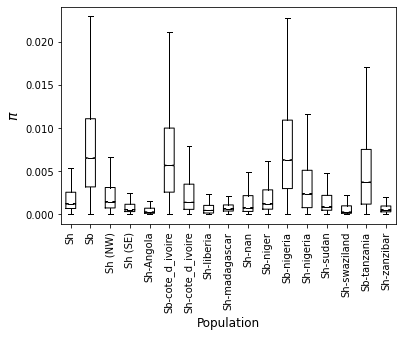

In [293]:
plt.boxplot([ sp_pi_dfs["s_haematobium"].dropna(subset=["pi"])["pi"],
              sp_pi_dfs["s_bovis"].dropna(subset=["pi"])["pi"],
              k_pi_dfs["sh_nw"].dropna(subset=["pi"])["pi"],
              k_pi_dfs["sh_se"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["angola"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_bovis"]["cote_d_ivoire"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["cote_d_ivoire"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["liberia"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["madagascar"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["nan"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["niger"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_bovis"]["nigeria"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["nigeria"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["sudan"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["swaziland"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_bovis"]["tanzania"].dropna(subset=["pi"])["pi"],
              sp_country_pi_dfs["s_haematobium"]["zanzibar"].dropna(subset=["pi"])["pi"] ],
             showfliers=False, 
             notch=True,
             labels=["Sh", "Sb", "Sh (NW)", "Sh (SE)", "Sh-Angola", "Sb-cote_d_ivoire", "Sh-cote_d_ivoire", "Sh-liberia", "Sh-madagascar", 
                     "Sh-nan", "Sb-niger", "Sb-nigeria", "Sh-nigeria", "Sh-sudan", "Sh-swaziland", "Sb-tanzania", "Sh-zanzibar" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.savefig("pi_boxplot_{}kb_windows.svg".format(window_kb_size))
plt.savefig("pi_boxplot_{}kb_windows.png".format(window_kb_size), dpi=300)
plt.show()


### Make table of mean Pi

In [294]:
# species, location(s), pi, conf
sp_s = []
loc_s= []
pi_s = []
n_s  = []

for sp in sp_pi_dfs.keys():
    df = sp_pi_dfs[sp]
    loc = "Africa"
    pi  = df[df["n_snps"]>10].dropna(subset=["pi"])["pi"].mean()
    n = len(sp_idxs[sp])
    
    sp_s.append(sp)
    pi_s.append(pi)
    loc_s.append(loc)
    n_s.append(n)
   
for k in k_pi_dfs.keys():
    df=k_pi_dfs[k]
    x = {"sb": "Africa", "sh_nw": "NW Africa", "sh_se": "SE Africa"}
    loc = x[k]
    pi  = df[df["n_snps"]>10].dropna(subset=["pi"])["pi"].mean()
    n = len(k_pop_idxs[k])
    
    sp_s.append(sp)
    pi_s.append(pi)
    loc_s.append(loc)
    n_s.append(n)
    

for sp in sp_country_pi_dfs.keys():
    for loc in sp_country_pi_dfs[sp].keys():
        df=sp_country_pi_dfs[sp][loc]
        pi  = df[df["n_snps"]>10].dropna(subset=["pi"])["pi"].mean()
        n = len(sp_country_idxs[sp][loc])

        sp_s.append(sp)
        pi_s.append(pi)
        loc_s.append(loc)
        n_s.append(n)
    
pi_df = pd.DataFrame(data = [sp_s, loc_s, n_s, pi_s]).T
pi_df.columns = ["Species", "Location", "n", "pi"]
pi_df.to_csv("mean_pi_{}kb_windows.csv".format(window_kb_size), index=False, sep=",")
pi_df

,Species,Location,n,pi
0,s_bovis,Africa,23,0.00764
1,s_haematobium,Africa,136,0.002248
2,s_haematobium,Africa,23,0.00764
3,s_haematobium,NW Africa,79,0.002572
4,s_haematobium,SE Africa,57,0.001357
5,s_bovis,nigeria,9,0.007479
6,s_bovis,ethiopia,1,0.003897
7,s_bovis,kenya,1,0.004516
8,s_bovis,senegal,1,0.003437
9,s_bovis,tanzania,3,0.004976


## Tajima's D

In [295]:
Path("{}/tajimas_d".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/tajimas_d".format(results_dir))

In [296]:
window_kb_size = 10

### Kmeans Tajima's D

In [374]:
#get pi per population NW vs SE vs bovis
k_td_dfs=defaultdict(lambda: pd.DataFrame(columns=["chrom", "start", "stop", "tajimas_d", "n_snps"]))

for k in k_pop_acs.keys():
    for chrom in tqdm(uniq_chroms):
        chrom_pos = poss[chroms == chrom]
        chrom_ac =  k_pop_acs[k][chroms == chrom]

        if len(chrom_ac) > 10:
            td, windows, counts =  allel.windowed_tajima_d(chrom_pos, chrom_ac, size=int(window_kb_size)*1_000, min_sites=3)

            #add info to a df
            chrs            = [chrom]*len(td)
            chr_df          = pd.DataFrame([td, windows[:,0], windows[:,1], counts]).T
            chr_df.columns  = ["tajimas_d", "start", "stop", "n_snps"]
            chr_df["chrom"] = chrom

            k_td_dfs[k]=k_td_dfs[k].append(chr_df)

            #reset index
            k_td_dfs[k]=k_td_dfs[k].reset_index(drop=True)

            #re-order
            k_td_dfs[k] = k_td_dfs[k][["chrom", "start", "stop", "n_snps", "tajimas_d"]]
            
            #save df to a csv
            k_td_dfs[k].to_csv("td_{}kb_windows_{}.csv".format(window_kb_size, k), index=False, sep=",")

 82%|████████▏ | 464/564 [18:25<04:04,  2.44s/it]/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/allel/stats/diversity.py:1047: RuntimeWarning: divide by zero encountered in long_scalars
  b2 = 2 * (n**2 + n + 3) / (9 * n * (n - 1))
/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/allel/stats/diversity.py:1048: RuntimeWarning: divide by zero encountered in double_scalars
  c1 = b1 - (1 / a1)
/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/allel/stats/diversity.py:1049: RuntimeWarning: divide by zero encountered in true_divide
  c2 = b2 - ((n + 2) / (a1 * n)) + (a2 / (a1**2))
/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/allel/stats/diversity.py:1049: RuntimeWarning: invalid value encountered in double_scalars
  c2 = b2 - ((n + 2) / (a1 * n)) + (a2 / (a1**2))
100%|██████████| 564/564 [22:01<00:00,  2.34s/it]


### Make a TD table

In [378]:
#merge all dfs into one
sb_tds = k_td_dfs["sb"]["tajimas_d"]
se_tds = k_td_dfs["sh_se"]["tajimas_d"]

td_df = k_td_dfs["sh_nw"].rename(columns = {"tajimas_d": "td_sh_nw"})
td_df["td_sh_se"] = se_tds
td_df["td_sb"] = sb_tds

td_df = td_df[["chrom", "start", "stop", "n_snps", "td_sb", "td_sh_nw", "td_sh_se"]]

td_df.to_csv("td_{}kb_windows_allpops.csv".format(window_kb_size), index=False, sep=",")
td_df

,chrom,start,stop,n_snps,td_sb,td_sh_nw,td_sh_se
0,NC_008074.1,180.0,10179.0,296.0,-0.564435,0.473794,2.196349
1,NC_008074.1,10180.0,12559.0,89.0,NaN,-0.742741,2.117318
2,NW_023366043.1,329.0,5288.0,232.0,0.469951,0.897245,-0.902501
3,NW_023366044.1,288.0,6268.0,258.0,-0.500382,0.972116,-0.512210
4,NW_023366045.1,2946.0,4498.0,21.0,NaN,-1.532747,NaN
...,...,...,...,...,...,...,...
37284,NW_023366702.1,59.0,6594.0,866.0,0.387400,1.052716,1.214353
37285,NW_023366703.1,2873.0,8090.0,73.0,1.250789,-1.141964,-0.590874
37286,NW_023366704.1,2185.0,3521.0,159.0,0.270279,-2.520215,-1.586829
37287,NW_023366705.1,1169.0,8969.0,172.0,-0.672302,-0.233310,-1.012078


In [380]:
print("pop\tmean tajima's D")
print("Sh (NW)\t{}".format(td_df["td_sh_nw"].mean()))
print("Sh (SE)\t{}".format(td_df["td_sh_se"].mean()))
print("Sb\t{}".format(td_df["td_sb"].mean()))

pop	mean tajima's D
Sh (NW)	-1.3744767277114798
Sh (SE)	-1.3380154496856393
Sb	-0.11040495812797148


### Plot Tajima's D

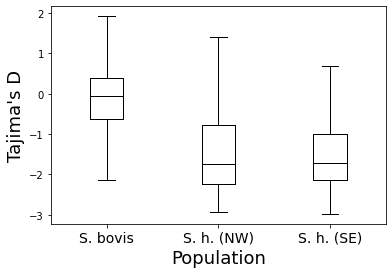

In [385]:
plt.boxplot([ td_df.dropna(subset=["td_sb"])["td_sb"],
              td_df.dropna(subset=["td_sh_nw"])["td_sh_nw"],
              td_df.dropna(subset=["td_sh_se"])["td_sh_se"] ],
              showfliers=False, 
              notch=False,
              labels=["S. bovis", "S. h. (NW)", "S. h. (SE)" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=0, fontsize=14)
plt.xlabel("Population", fontsize=18)
plt.ylabel("Tajima's D", fontsize=18)
plt.savefig("td_{}kb_windows_allpops.svg".format(window_kb_size))
plt.savefig("td_{}kb_windows_allpops.png".format(window_kb_size), dpi=300)
plt.show()


## Ne

In [ ]:
Path("{}/ne".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/ne".format(results_dir))

# Ancestry and introgression

## F3

The expected ouptuts from F3 via scikit-allel

```
f3 = Estimated value of the statistic using all data.
se = Estimated standard error.
z  = Z-score (number of standard errors from zero).
vb = Value of the statistic in each block.
vj = Values of the statistic from block-jackknife resampling
```


Is NW SH admixed?

In [99]:
f3, se, z, vb_nw, vj = allel.average_patterson_f3(k_ac["Sh (NW)"], k_ac["Sh (SE)"], k_ac["Sb"], 500, normed=True)
print("f3={}, SE={}, Z={}: f3(C: A, B = SH_NW: SH_SE, SB)".format(f3, se, z))

f3=-0.1147713696528147, SE=0.0007644922510724643, Z=-150.12757747617223: f3(C: A, B = SH_NW: SH_SE, SB)


Is SE SH admixed?

In [100]:
f3, se, z, vb_se, vj = allel.average_patterson_f3(k_ac["Sh (SE)"], k_ac["Sh (NW)"], k_ac["Sb"], 500, normed=True)
print("f3={}, SE={}, Z={}: f3(C: A, B = SH_SE: SH_NW, SB)".format(f3, se, z))

f3=0.5102330334500964, SE=0.004225118197946318, Z=120.76183660331746: f3(C: A, B = SH_SE: SH_NW, SB)


In [ ]:
#now lets do this per country


Based of the results from these analyses, Sh from NW Africa has a *significant* signature of admixture with SE SH and Sb, the same signal is _NOT_ present when comparing SE SH with NW SH and Sb

## D: ABBA BABA

The expected ouptuts from F3 via scikit-allel


```
d = Estimated value of the statistic using all data.
se = Estimated standard error.
z = Z-score (number of standard errors from zero).
vb = Value of the statistic in each block.
vj = Values of the statistic from block-jackknife resampling.
```

https://www.genetics.org/content/192/3/1065

In [179]:
Path("{}/abba_baba".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/abba_baba".format(results_dir))

In [ ]:
#get outgroup ac (S. margrebowiei)
outgroup_idxs = list(samples).index("margrebowiei_zambia_ERR310940")
out_ac =  gt.count_alleles(subpop=kmeans_pop_idxs[k])

D=0.6341401046001398, SE=0.005975343067937009, Z=106.12614161065686


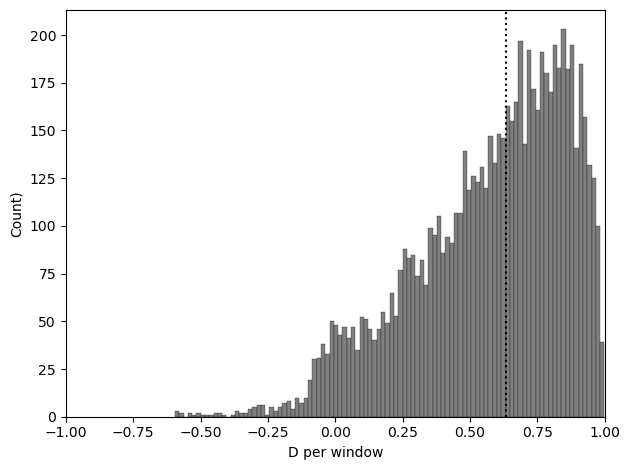

In [183]:
d, se, z, vb, vj = allel.average_patterson_d(k_ac["Sh (NW)"], k_ac["Sh (SE)"], k_ac["Sb"], out_ac, 5000)

print("D={}, SE={}, Z={}".format(d, se, z))
plt.hist(vb, bins=100, color="grey",  edgecolor="black", linewidth=0.2)
plt.xlim([-1,1])
plt.axvline(d, color = 'black', linestyle = ':')
plt.ylabel("Count)".format(k))
plt.xlabel("D per window")
plt.tight_layout()

plt.savefig("d_hist.svg".format(k))
plt.savefig("d_hist.png".format(k), dpi=300)

plt.show()

## Local ancestry (LOTER)

In [12]:
# Path("{}/loter".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/loter".format(results_dir))

Path("{}/loter/vcf_files".format(results_dir)).mkdir(parents=True, exist_ok=True)
Path("{}/loter/csv_files".format(results_dir)).mkdir(parents=True, exist_ok=True)

## Prep and run Loter

For Loter we need reference samples from each "parental" population.  Here I am using a random selection of Sh from islands of the E. Coast of Africa (Madagascar or Zanzibar).  Our previous paper plus Rey et al show these populations have minimal (if any) S. bovis alleles. For S. bovis we are using 

In [4]:
%%bash

#get random "pure" haematboium
vcftools \
    --vcf ../phasing/beagle.vcf \
    --keep ../admixture/sh_ref.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >vcf_files/haem_ref_loter.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../phasing/beagle.vcf
	--keep ../admixture/sh_ref.list
	--recode-INFO-all
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 11 out of 163 Individuals
Outputting VCF file...
After filtering, kept 34833640 out of a possible 34833640 Sites
Run Time = 1852.00 seconds


In [5]:
%%bash 

#get bovis samples
vcftools \
    --vcf ../phasing/beagle.vcf \
    --keep ../admixture/sb_ref.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >vcf_files/bovis_ref_loter.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../phasing/beagle.vcf
	--keep ../admixture/sb_ref.list
	--recode-INFO-all
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 17 out of 163 Individuals
Outputting VCF file...
After filtering, kept 34833640 out of a possible 34833640 Sites
Run Time = 1914.00 seconds


In [14]:
%%bash

#get query samples by removing outgroups and bovis/haem references
echo -e "guineensis_saotome_ERR119612\nintercalatum_drcongo_ERR119613\nmargrebowiei_zambia_ERR310940\nmatthei_zambia_ERR103051">outgroup.list

cat ../admixture/sb_ref.list ../admixture/sh_ref.list outgroup.list >remove.list

vcftools \
    --vcf ../phasing/beagle.vcf \
    --remove remove.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >vcf_files/query_loter.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../phasing/beagle.vcf
	--remove remove.list
	--recode-INFO-all
	--recode
	--stdout

Excluding individuals in 'exclude' list
After filtering, kept 131 out of 163 Individuals
Outputting VCF file...
After filtering, kept 34833640 out of a possible 34833640 Sites
Run Time = 2247.00 seconds


Get some relevant info from the query samples for post-porcessing (slighlty different from the same code at the top of the notebook that reads in this info from the VCF file containing all samples.)

In [8]:
#get info from vcf
callset = allel.read_vcf("vcf_files/query_loter.vcf")

#get relevant info
chroms    = callset["variants/CHROM"]
q_samples = callset["samples"]
poss      = callset["variants/POS"]
var_ids   = callset["variants/ID"]

#get the INDEX of where each chromosome begins and ends in the genotyping array.  Ex. Chr1 is from pos 1-280 in the array, Chr2 is 281-404.  
# THERE IS A DIFFERENCE BETWEEN THE INDEX (IN THE ARRAY) AND POSITION IN THE GENOME
chrom_idxs={}
uniq_chroms=np.unique(chroms)
for chrom in tqdm(uniq_chroms):
    idxs=list(np.where(chroms == chrom)[0])
    start=min(idxs)
    stop=max(idxs)
    chrom_idxs[chrom]=[start, stop]

#get samples and haplotype ids
hap_ids=[]
for sample in q_samples:
    hap_ids.append("{}_h1".format(sample))
    hap_ids.append("{}_h2".format(sample))
    
np.savetxt("hap_ids.csv", hap_ids, fmt="%s", delimiter=",")

#del callset

100%|██████████| 550/550 [06:55<00:00,  1.32it/s]


vcf2npy` convert a VCF File to a numpy matrix with values 0, 1 and 2.

This is a function provided by the `loter`'s example notebook and reads in a vcf to a numpy array of haplotypes (columns = variants, rows = haplotypes)

In [252]:
def vcf2npy(vcfpath):
    callset = allel.read_vcf(vcfpath)
    haplotypes_1 = callset['calldata/GT'][:,:,0]
    haplotypes_2 = callset['calldata/GT'][:,:,1]
    
    m, n = haplotypes_1.shape
    mat_haplo = np.empty((2*n, m))
    mat_haplo[::2] = haplotypes_1.T
    mat_haplo[1::2] = haplotypes_2.T
    
    return mat_haplo.astype(np.uint8)

In [253]:
#read in vcfs and covert to hs
bovis_hs = vcf2npy("vcf_files/bovis_ref_loter.vcf")
print("bovis done")
haem_hs  = vcf2npy("vcf_files/haem_ref_loter.vcf")
print("haem done")
query_hs = vcf2npy("vcf_files/query_loter.vcf")
print("query done")

bovis done
haem done
query done


Run loter on one chromosome at a time and store as a csv file

In [254]:
Path("{}/loter/h_files".format(results_dir)).mkdir(parents=True, exist_ok=True)

for chrom in tqdm(uniq_chroms):

    start_idx = chrom_idxs[chrom][0]
    stop_idx  = chrom_idxs[chrom][1]+1
    
    #split hs
    chr_bovis_hs = bovis_hs[:,start_idx:stop_idx]
    chr_haem_hs  = haem_hs[ :,start_idx:stop_idx]
    chr_query_hs = query_hs[:,start_idx:stop_idx]
    
    #get var_ids and save to file
    ids=var_ids[start_idx:stop_idx]
    np.savetxt("h_files/{}_variant_ids.csv".format(chrom), ids, fmt="%s", delimiter=",")

    
    #set up files for output
    bovis_out ="h_files/hs_bovis_{}".format(chrom)
    haem_out  ="h_files/hs_haem_{}".format(chrom)
    query_out ="h_files/hs_query_{}".format(chrom)

    #save otuput
    np.save(bovis_out, chr_bovis_hs, allow_pickle=True, fix_imports=True)
    np.save(haem_out,  chr_haem_hs,  allow_pickle=True, fix_imports=True)
    np.save(query_out, chr_query_hs, allow_pickle=True, fix_imports=True)

100%|██████████| 550/550 [17:35<00:00,  1.92s/it]  
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2b33ebb03c40>>
Traceback (most recent call last):
  File "/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/distributed/utils_perf.py", line 192, in _gc_callback
    self._fractional_timer.start_timing()
  File "/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/distributed/utils_perf.py", line 115, in start_timing
    assert self._cur_start is None
AssertionError: 


In [ ]:
%%bash

QSUB="qsub -V -cwd -S /bin/bash -q high_mem.q -j y -p -1023 -pe smp 8 " 
CONDA="conda activate /master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry"

# #ingroup_indv_and_site_filt.vcf
# cut -f1 results/phasing/beagle.vcf \
#     | grep -v "#" \
#     | sort \
#     | uniq -c \
#     | awk '{ if ($1>1) print $2}' \
#     >results/loter/loter_chroms.list

#now run them in batch
for CHROM in $(cat results/loter/loter_chroms.list); do
    CMD="python /master/nplatt/sch_hae_scan/code/single_chrom_loter.py "$CHROM

    echo "$CONDA; $CMD"  | $QSUB -N loter_$CHROM -o results/loter/$CHROM.log

done



## QC Loter results

In [19]:
hap_ids=np.loadtxt("hap_ids.csv", dtype='str')

In [256]:
missing=[]

for chrom in uniq_chroms:
    try:
        os.path.exists("csv_files/loter_{}_T.csv".format(chrom))
        #loter_chrom_dfs[chrom]=dask.dataframe.read_csv("csv_files/loter_{}.csv".format(chrom), sep=",", blocksize=None, sample=40_000_000)    
    except:
        #print("{} missing".format(chrom))
        missing.append(chrom)
        pass
    
print(missing)

[]


In [257]:
count_chroms, counts =np.unique(chroms, return_counts=True)

In [258]:
for chrom, count in zip(count_chroms, counts):
    #open loter file
    with open("csv_files/loter_{}_T.csv".format(chrom), 'r') as in_file:
        i=0
        for line in in_file:
            i=i+1
            
        i=i-1
        
        if i != count:
            print("Something happened to {}: {}\t{}".format(chrom, count, i))


In [37]:
# loter_chrom_dfs={}

# #get each chrom that has a loter output file (should be around 550)
# for loter_file in tqdm(glob.glob("csv_files/loter_N*.csv")):
#     chrom = loter_file.replace("csv_files/loter_", "").replace("_T.csv", "")

#     #read in loter file
#     chrom_loter_df=pd.read_csv("csv_files/loter_{}_T.csv".format(chrom), sep=",", index_col=0)
#     loter_chrom_dfs[chrom] = chrom_loter_df

100%|██████████| 550/550 [07:17<00:00,  1.26it/s]


## How many bovis alleles per individual

In [394]:
var_ids=filtered_callset["variants/ID"]

In [9]:
ddf=dask.dataframe.read_csv("csv_files/loter_*_T.csv", sep=",", blocksize=None, sample=256_000, header=0)   

In [262]:
#get the per indiv num of bovis alleles
with ProgressBar():
    per_indv=ddf.sum(axis=0).compute()

#convert to a df and format
per_indv_df = per_indv.to_frame()
per_indv_df = per_indv_df.iloc[1: , :]

per_indv_df.columns=["n_bovis_alleles"]

#divide by total num of alleles
per_indv_df["n_bovis_perc"] = per_indv_df["n_bovis_alleles"]/n_snvs

#now add the pca kmeans group label to each sample (haplotype)
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")

#store the kmeans labels for each HAPLOTYPE into a hap_labels dictionary
hap_labels={}
for hap_id in per_indv_df.index:
    sample="_".join(hap_id.split("_")[:-1])
    k_label=pca_df.loc[pca_df["sample_name"]==sample]["kmeans_label"].values[0]
    hap_labels[hap_id]=k_label
    
#now match the label with the sample in the wg df
k_labels=[]
for sample in per_indv_df.index:
    k_labels.append(hap_labels[sample])
    
#and add a new column to track the k groups for each sample
per_indv_df["kmeans_labels"]=k_labels

#save to csv
per_indv_df.to_csv("perc_bovis_per_indiv.csv", sep=",")

,n_bovis_alleles,n_bovis_perc,kmeans_labels
Sb_NG_au_2.13_h1,34642976,0.994526,Sb
Sb_NG_au_2.13_h2,34806260,0.999214,Sb
Sb_NG_au_2.5_h1,34640963,0.994469,Sb
Sb_NG_au_2.5_h2,34813809,0.999431,Sb
Sb_NG_be_1.5_h1,34657602,0.994946,Sb
...,...,...,...
ssp_niger_libore_169_h2,1958641,0.056228,Sh (NW)
ssp_niger_libore_173_h1,3184773,0.091428,Sh (NW)
ssp_niger_libore_173_h2,1963530,0.056369,Sh (NW)
ssp_zambia_kafue_71_h1,1025092,0.029428,Sh (SE)


In [ ]:
per_indv_df=pd.read_csv("perc_bovis_per_indiv.csv", sep=",")

In [263]:
se_df=per_indv_df.loc[per_indv_df["kmeans_labels"]=="Sh (SE)"].drop(["kmeans_labels"], axis=1).sort_values("n_bovis_perc")
nw_df=per_indv_df.loc[per_indv_df["kmeans_labels"]=="Sh (NW)"].drop(["kmeans_labels"], axis=1).sort_values("n_bovis_perc")
sb_df=per_indv_df.loc[per_indv_df["kmeans_labels"]=="Sb"].drop(["kmeans_labels"], axis=1).sort_values("n_bovis_perc")

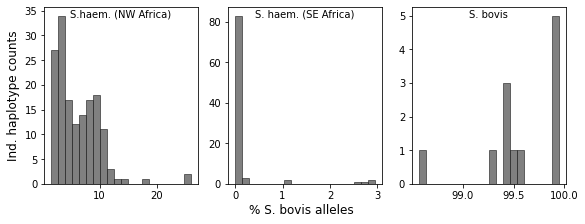

In [264]:
fig, (ax_nw, ax_se, ax_sb) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax_nw.hist(nw_df["n_bovis_perc"]*100, bins=20, alpha=1, label="S.h. (NW)", color='grey', edgecolor="black", linewidth=0.5)
ax_nw.set_title("S.haem. (NW Africa)", fontsize=10, y=1.0, pad=-10)

ax_se.hist(se_df["n_bovis_perc"]*100, bins=20, alpha=1, label="S.h. (SE)", color='grey', edgecolor="black", linewidth=0.5)
ax_se.set_title("S. haem. (SE Africa)", fontsize=10, y=1.0, pad=-10)

ax_sb.hist(sb_df["n_bovis_perc"]*100, bins=20, alpha=1, label="S. bovis", color='grey', edgecolor="black", linewidth=0.5)
ax_sb.set_title("S. bovis", fontsize=10, y=1.0, pad=-10)


fig.text(0.00, 0.25, 'Ind. haplotype counts', ha='center', rotation='vertical', fontsize=12)
fig.text(0.5, -0.01, '% S. bovis alleles', ha='center', fontsize=12)
fig.tight_layout()
plt.savefig("percent_bovis_per_indiv.svg")
plt.savefig("percent_bovis_per_indiv.png", dpi=300)
plt.show()

In [265]:
se_df["n_bovis_perc"].mean()*100

0.17966512306469562

In [266]:
nw_df["n_bovis_perc"].mean()*100

6.25902752030523

In [267]:
sb_df["n_bovis_perc"].mean()*100

99.57983456030817

## Excess Sb alleles at each position

In [23]:
#read in all non-mito loter files into a dask data frame (and drop column with variant ids)
ddf=dask.dataframe.read_csv("csv_files/loter_NW*_T.csv", sep=",", blocksize=None, sample=256_000, header=0)
ddf.head()

,Unnamed: 0,Sb_NG_au_2.13_h1,Sb_NG_au_2.13_h2,Sb_NG_au_2.5_h1,Sb_NG_au_2.5_h2,Sb_NG_be_1.5_h1,Sb_NG_be_1.5_h2,Sh_NG_eb_6_2_h1,Sh_NG_eb_6_2_h2,Sh_NG_ed_1_3_h1,...,ssp_niger_libore_167_h1,ssp_niger_libore_167_h2,ssp_niger_libore_168_h1,ssp_niger_libore_168_h2,ssp_niger_libore_169_h1,ssp_niger_libore_169_h2,ssp_niger_libore_173_h1,ssp_niger_libore_173_h2,ssp_zambia_kafue_71_h1,ssp_zambia_kafue_71_h2
0,NW_023366043.1:329,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
1,NW_023366043.1:341,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
2,NW_023366043.1:367,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
3,NW_023366043.1:384,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
4,NW_023366043.1:399,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


In [24]:
per_indv_df=pd.read_csv("perc_bovis_per_indiv.csv", sep=",")
k_labels=per_indv_df["kmeans_labels"]

In [25]:
#get idxs in the df for each pca k population
per_indv_df=pd.read_csv("perc_bovis_per_indiv.csv", sep=",")
k_labels=per_indv_df["kmeans_labels"]

k_idxs={}    
for k_label in set(k_labels):
    #np.where returns tuple.  get rid of it
    k_idxs[k_label]=np.where(np.array(k_labels)==k_label)[0]

In [ ]:
#extract each pop from the dask dataframe and sum the number of bovis variants at each site
sb_per_site = ddf.iloc[:,k_idxs['Sb'] + 1      ].sum(axis='columns').compute()
nw_per_site = ddf.iloc[:,k_idxs['Sh (NW)'] + 1 ].sum(axis='columns').compute()
se_per_site = ddf.iloc[:,k_idxs['Sh (SE)'] + 1 ].sum(axis='columns').compute()

#divide the number of bovis variants by the number of samples to get % bovis at each site
sb_per_site = sb_per_site/len(k_idxs['Sb'])
nw_per_site = nw_per_site/len(k_idxs['Sh (NW)'])
se_per_site = se_per_site/len(k_idxs['Sh (SE)'])

In [ ]:
#get the variant ids
loter_var_ids=ddf.iloc[:,0].compute()

In [29]:
#check to make sure we have the number of variants expected
lvi = len(loter_var_ids)
vi  = len(var_ids)

print("loter_var_ids: n = {}".format(lvi))
print("var_ids: n = {}".format(vi))


loter_var_ids: n = 34833255
var_ids: n = 37131010


In [30]:
lchroms = []
poss = [] 

print("getting ids")
for loter_var_id in tqdm(loter_var_ids):
    chrom, pos = loter_var_id.split(":")
    lchroms.append(chrom)
    poss.append(pos)

print("initialize df")
#now turn this data into a df
df=pd.DataFrame( columns = [ "chrom", 
                             "pos", 
                             "variant_id", 
                             "NW", 
                             "SE", 
                             "Sb"])

print("populate chroms")
df["chrom"] = lchroms
print("populate poss")
df["pos"] = poss
print("populate ids")
df["variant_id"]=list(loter_var_ids)
print("populate nw")
df["NW"]=list(nw_per_site)
print("populate se")
df["SE"]=list(se_per_site)
print("populate sb")
df["Sb"]=list(sb_per_site)

print("writing to file")
df.to_csv("perc_bovis_per_site.csv", sep=",", index=False)
df.head()

  0%|          | 173820/34833255 [00:00<00:19, 1738060.77it/s]

getting ids


100%|██████████| 34833255/34833255 [00:17<00:00, 1953129.32it/s]


initialize df
populate chroms
populate poss
populate ids
populate nw
populate se
populate sb
writing to file


,chrom,pos,variant_id,NW,SE,Sb
0,NW_023366043.1,329,NW_023366043.1:329,0.810127,0.043478,1.0
1,NW_023366043.1,341,NW_023366043.1:341,0.810127,0.043478,1.0
2,NW_023366043.1,367,NW_023366043.1:367,0.810127,0.043478,1.0
3,NW_023366043.1,384,NW_023366043.1:384,0.810127,0.043478,1.0
4,NW_023366043.1,399,NW_023366043.1:399,0.810127,0.043478,1.0


In [38]:
ys=df["NW"]-df["SE"]
xs=range(0,len(ys))

figure(figsize=(7, 3), dpi=300)
plt.scatter(xs, ys, c=ys, cmap="cool", s=0.5, vmin=-1, vmax=1)
plt.colorbar()
plt.ylim(-1, 1)
plt.xlim([-500_000,xs[-1]+500_000])
plt.axhline(0.90,  lw=1, linestyle=":", c="black")
plt.axhline(-0.90, lw=1, linestyle=":", c="black")
plt.axhline(0, lw=1, c="black")
plt.xlabel("Scaffold position")
plt.ylabel("Excess S. bovis ancestry")
plt.xticks([])
plt.tick_params(labelbottom=False, length=7) 

plt.savefig("perc_bovis_per_site.png", dpi=300)

#plt.show()
plt.close()

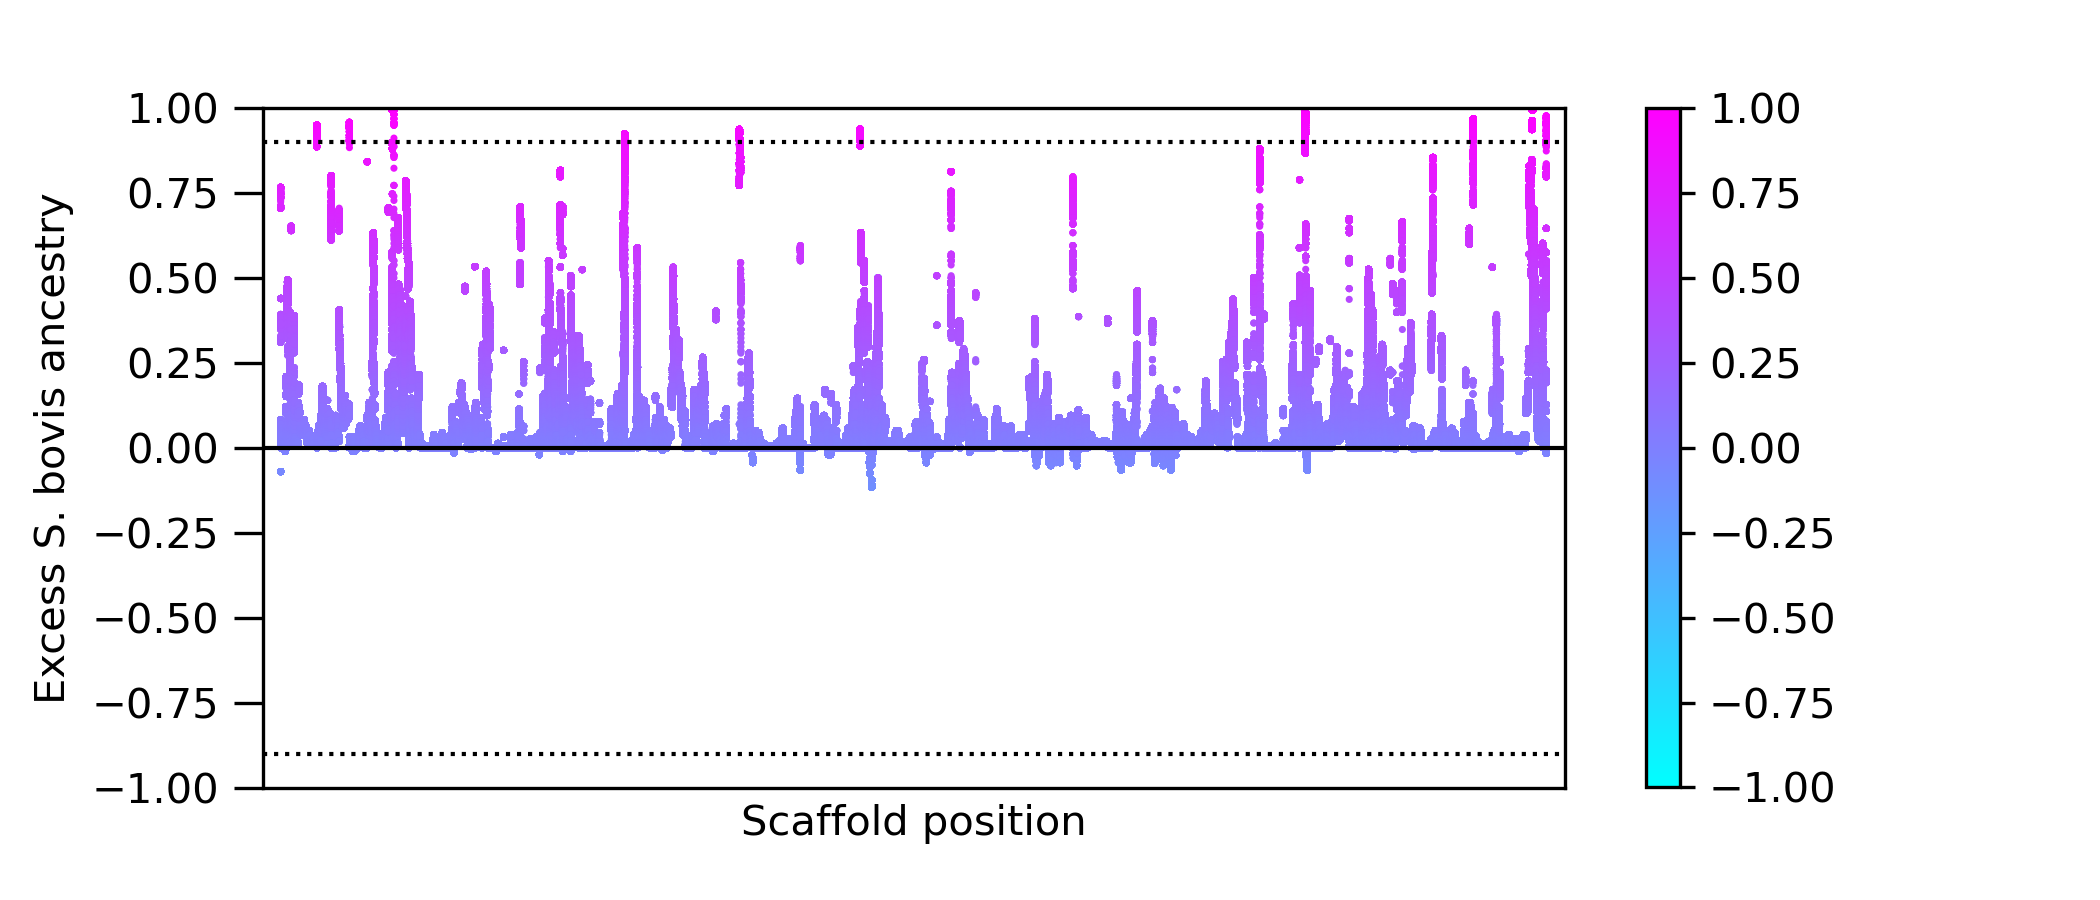

In [39]:
Image("perc_bovis_per_site.png")

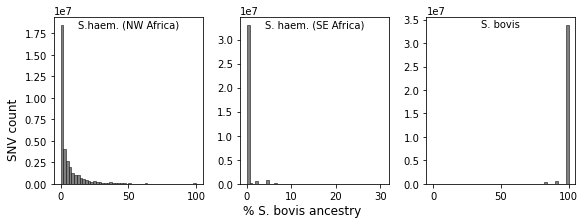

In [36]:
#make histograms of the per site Sb alleles
fig, (ax_nw, ax_se, ax_sb) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax_nw.hist(df["NW"]*100, bins=50, alpha=1, label="S.h. (NW)", color='grey', edgecolor="black", linewidth=0.5)
ax_nw.set_title("S.haem. (NW Africa)", fontsize=10, y=1.0, pad=-10)

ax_se.hist(df["SE"]*100, bins=50, alpha=1, label="S.h. (SE)", color='grey', edgecolor="black", linewidth=0.5)
ax_se.set_title("S. haem. (SE Africa)", fontsize=10, y=1.0, pad=-10)

ax_sb.hist(df["Sb"]*100, bins=50, alpha=1, label="S. bovis", color='grey', edgecolor="black", linewidth=0.5)
ax_sb.set_title("S. bovis", fontsize=10, y=1.0, pad=-10)


fig.text(0.00, 0.25, 'SNV count', ha='center', rotation='vertical', fontsize=12)
fig.text(0.5, -0.01, '% S. bovis ancestry', ha='center', fontsize=12)
fig.tight_layout()
plt.savefig("per_bovis_per_site_histogram.svg")
plt.savefig("per_bovis_per_site_histogram.png", dpi=300)
plt.show()

## Which sites and loci have an excess of Sb alleles (90% or greater)?

In [13]:
#df = pd.read_csv("perc_bovis_per_site.csv", sep=",")
ddf = dask.dataframe.read_csv("perc_bovis_per_site.csv", sep=",", blocksize=None, sample=256_000)
ddf.head()

,chrom,pos,variant_id,NW,SE,Sb
0,NC_008074.1,180,NC_008074.1:180,0.56962,0.0,1.0
1,NC_008074.1,199,NC_008074.1:199,0.56962,0.0,1.0
2,NC_008074.1,207,NC_008074.1:207,0.56962,0.0,1.0
3,NC_008074.1,219,NC_008074.1:219,0.56962,0.0,1.0
4,NC_008074.1,240,NC_008074.1:240,0.56962,0.0,1.0


In [20]:
df_90 = ddf.loc[ddf["NW"] >= 0.90].compute()
df_90.to_csv("sb_snvs_at_90p_in_nw.csv", sep=",", header=0, index=False)

#now convert to a bed
df_90_bed=df_90[["chrom", "pos"]]
df_90_bed["stop"] = df_90_bed["pos"] + 1
df_90_bed.to_csv("sb_snvs_at_90p_in_nw.bed", sep="\t", header=False, index=False)

/master/nplatt/sch_hae_scan/envs/jupyterlab_ancestry/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [21]:
snvs_bed = pybedtools.BedTool("sb_snvs_at_90p_in_nw.bed")
loci_bed = snvs_bed.merge(d=100_000)
loci_bed.saveas('sb_loci_at_90p_in_nw.bed')
loci_df = loci_bed.to_dataframe()
loci_df

,chrom,start,end
0,NW_023366070.1,3708,14958
1,NW_023366099.1,250,2694
2,NW_023366109.1,5842727,6454176
3,NW_023366241.1,6722397,6725661
4,NW_023366290.1,85072,294879
5,NW_023366330.1,3311,4836
6,NW_023366419.1,174,831
7,NW_023366560.1,548,71950
8,NW_023366652.1,2676,170279
9,NW_023366679.1,8400451,8636063


## Which genes have high Sb. ancestry

In [86]:
# gff_file = "{}/data/GCF_000699445.2_SchHae_2.0_genomic.gff".format(proj_dir)

# gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True, merge_strategy="create_unique", sort_attribute_values=True)
# gff_db = gffutils.FeatureDB('gff.db', keep_order=True)

with open("genes_in_sb_loci.csv", 'w') as out_f:
    outline = "gene,chrom,start,stop,locus\n"
    out_f.write(outline)
    
    for loci in loci_bed:
        genes = gff_db.region(region=(loci.chrom, loci.start, loci.stop), completely_within=False, featuretype=['gene'])
        for gene in genes:
            outline="{},{},{},{},{}:{}-{}".format(gene.id, gene.chrom, gene.start, gene.stop, loci.chrom, loci.start, loci.stop)
            out_f.write("{}\n".format(outline))

In [87]:
genes_df=pd.read_csv("genes_in_sb_loci.csv", header=0, sep=",")
genes_df

,gene,chrom,start,stop,locus
0,gene-MS3_0018266,NW_023366109.1,5870182,5904252,NW_023366109.1:5842727-6454176
1,gene-MS3_0018267,NW_023366109.1,5913537,5921455,NW_023366109.1:5842727-6454176
2,gene-MS3_0018268,NW_023366109.1,5926902,5927822,NW_023366109.1:5842727-6454176
3,gene-MS3_0018269,NW_023366109.1,5954684,6002331,NW_023366109.1:5842727-6454176
4,gene-MS3_0018270,NW_023366109.1,6022780,6033938,NW_023366109.1:5842727-6454176
5,gene-MS3_0018271,NW_023366109.1,6071450,6085048,NW_023366109.1:5842727-6454176
6,gene-MS3_0018272,NW_023366109.1,6132005,6136032,NW_023366109.1:5842727-6454176
7,gene-MS3_0018273,NW_023366109.1,6137134,6137427,NW_023366109.1:5842727-6454176
8,gene-MS3_0018274,NW_023366109.1,6145930,6154021,NW_023366109.1:5842727-6454176
9,gene-MS3_0018275,NW_023366109.1,6215382,6242066,NW_023366109.1:5842727-6454176


## Ancestry at invadolysin

In [276]:
# Ancestry at invadolysin
#NW_023366679.1:8567548-8600607

chr_df = df.loc[df["chrom"] == "NW_023366679.1"]
chr_df

100%|██████████| 34833640/34833640 [20:10<00:00, 28778.73it/s]


In [268]:
nw_y=chr_df["NW"]
se_y=chr_df["SE"]
sb_y=chr_df["Sb"]
x   =list(chr_df["pos"])

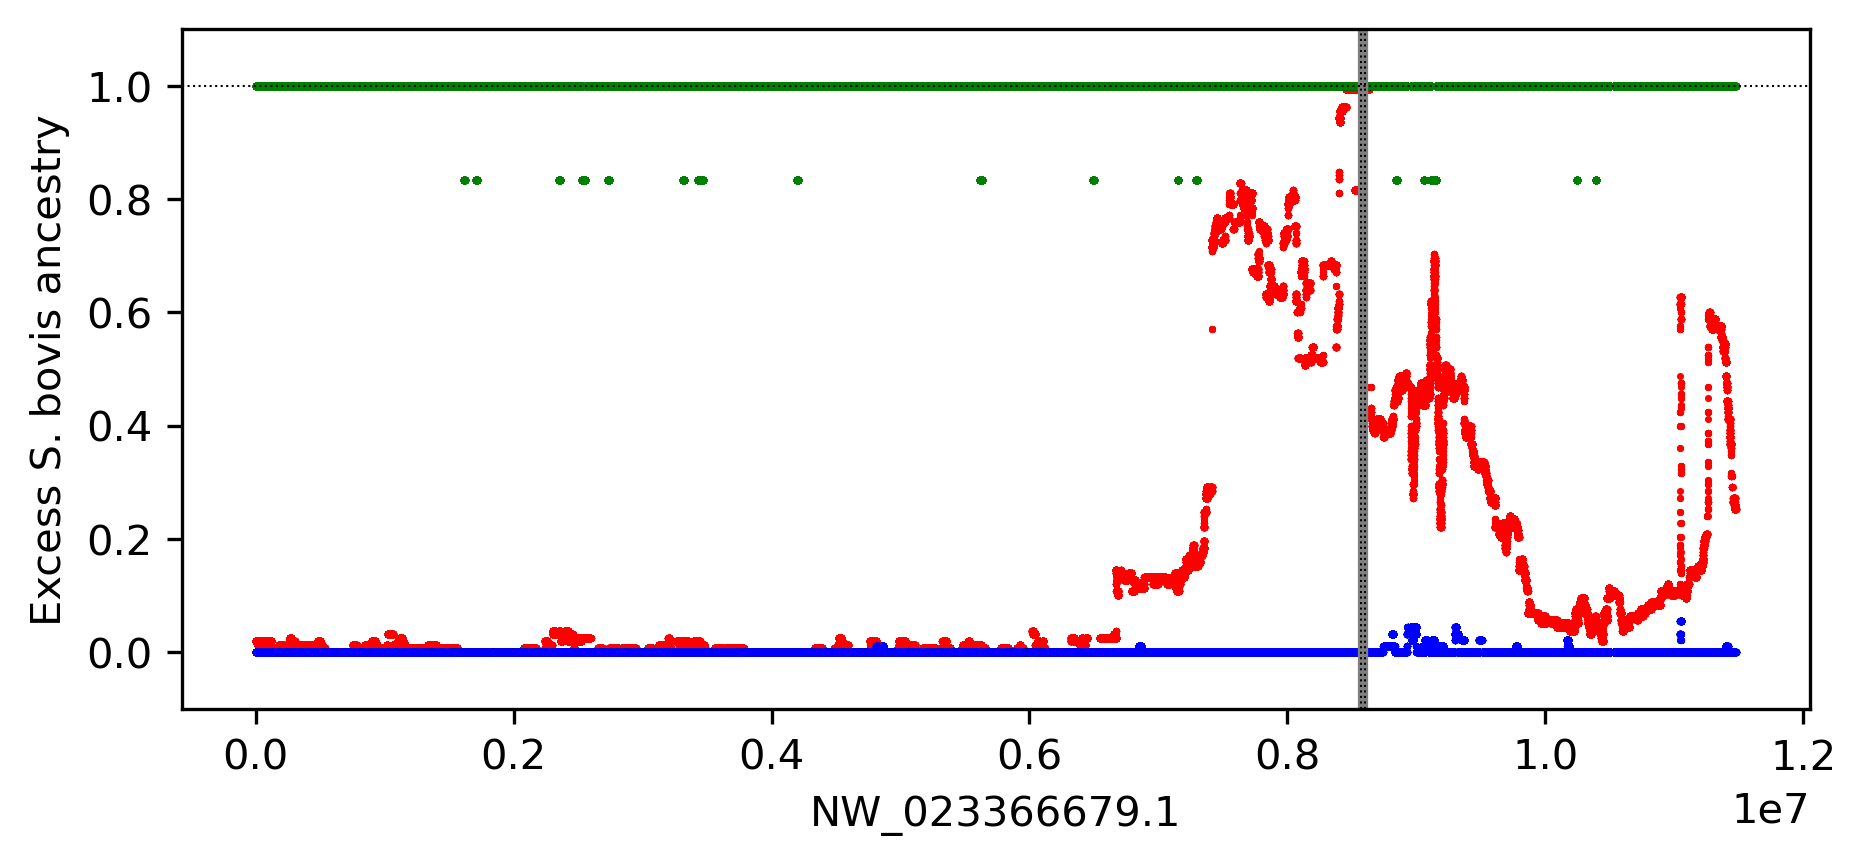

In [271]:
figure(figsize=(7, 3), dpi=300)
plt.scatter(x, nw_y, c="red",   s=0.5, label = "NW")
plt.scatter(x, se_y, c="blue",  s=0.5, label = "SE")
plt.scatter(x, sb_y, c="green", s=0.5, label = "Sb")

# plt.scatter(x, se_y, c="blue", s=0.5, label = "SE")
# plt.scatter(x, sb_y, c="green", s=0.5, label = "Sb")

plt.ylim(-0.1, 1.1)
#plt.xlim([0,x[-1]])
plt.axhline(1,  lw=0.5, linestyle=":", c="black")
#plt.axhline(-0.95, lw=1, linestyle=":", c="black")
plt.axvline(8_567_548, lw=0.5, linestyle=":", c="black")
plt.axvline(8_600_607, lw=0.5, linestyle=":", c="black")

#plt.axhline(0, lw=1, c="black")
plt.xlabel("NW_023366679.1")
plt.ylabel("Excess S. bovis ancestry")
#plt.xticks([8_567_548, 8_567_548])
#plt.tick_params(labelbottom=False, length=7) 

plt.vlines(8_567_548, -2, 2, colors="grey")
plt.vlines(8_600_607, -2, 2, colors="grey")

plt.savefig("{}/loter/sb_ancestry_at_invadolysin.png".format(results_dir), dpi=300)

plt.show()
plt.close()

## Dating admixture

### based on hap block length

In [516]:
hap_ids = [line.rstrip() for line in open('hap_ids.csv')]

nw_idxs = []
i=0
for hap_id in hap_ids:
    sample="_".join(hap_id.split("_")[:-1])
    k_label=pca_df.loc[pca_df["sample_name"]==sample]["kmeans_label"].values[0]
    if k_label == "sh_nw":
        nw_idxs.append(i)
    i+=1
    
nw_hap_ids = list(np.array(hap_ids)[nw_idxs])

In [553]:
loter_chrom_dfs={}

genotype_label={0: "Sh", 1: "Sb"}

#get hap block lengths per hap_id
hap_block_lengths=defaultdict(lambda: list())
csv_outs=[]

with open("sb_hap_blocks_in_sh_nw_on_chr_gt_1mb.csv",'w') as out_f:
    out_f.write("haplotype,chrom,start,stop,length,ancestry\n")
    
#get each chrom that has a loter output file (should be around 550)
for loter_file in tqdm(glob.glob("csv_files/loter_N*.csv")):
    chrom = loter_file.replace("csv_files/loter_", "").replace("_T.csv", "")

    #read in loter file
    chrom_loter_df=pd.read_csv("csv_files/loter_{}_T.csv".format(chrom), sep=",", index_col=0)
    loter_chrom_dfs[chrom] = chrom_loter_df
    chrom_loter_df=chrom_loter_df.T
    chrom_loter_df.index.name="sample_id"

    #ignore chrom if less than 1Mb
    chrom_len=int(chrom_loter_df.columns[-1].split(":")[-1])
    if chrom_len > 1_000_000:
    
        #convert to 2d numpy array
        chrom_loter_numpy=chrom_loter_df.to_numpy()

        #subset on the NW S. haem
        nw_chrom_loter_numpy=np.array(chrom_loter_df.iloc[nw_idxs,])

        #for each individual (listed on a row)
        for i in range(0, len(nw_chrom_loter_numpy)):
           
            #get the haplotype id
            hap_id = nw_hap_ids[i]

            #get initial starting index (used to get the position of the snv/hap block)
            start=0

            #compress the data into block sizes and types ex:
            # [(0, 649630), (1, 809), (0, 12779)]
            # This is read as three blocks with
            # the 1st block is genotype 0 and is 649_630 variants long
            # the 2nd block is genotype 1 and is 809 variants long
            # the 3rd block is genotype 0 and is 12_779 variants long
            
            hap_blocks = [(k, sum(1 for j in g)) for k,g in groupby(list(nw_chrom_loter_numpy[i]))]

            #go through each block
            for genotype, length in hap_blocks:
                
                #get the chrom and start pos from the variant id
                chrom, start_pos=chrom_loter_df.columns[start].split(":")
                
                #get the stop position from the variant id by looking at the block length and then getting the SNV that is that many idexes down 
                stop_pos=chrom_loter_df.columns[start+length-1].split(":")[-1]

                #get the length of the haplotype block (with some error checking)
                hap_block_length=int(stop_pos)-int(start_pos)+1
                if hap_block_length < 0:
                    print("error; {} {}", chrom, hap_id)
                    break
                    
                #write the block length/genotype info to a csv outfile
                csv_out="{},{},{},{},{},{}\n".format(hap_id, chrom, start_pos, stop_pos, hap_block_length, genotype_label[genotype])
                csv_outs.append(csv_out)
        
#save block info as a csv for downstream processing
with open("sb_hap_blocks_in_sh_nw_on_chr_gt_1mb.csv",'a') as out_f:
    for entry in csv_outs:
        out_f.write(entry)

100%|██████████| 550/550 [23:20<00:00,  2.55s/it]  


100%|██████████| 158/158 [00:02<00:00, 73.13it/s]


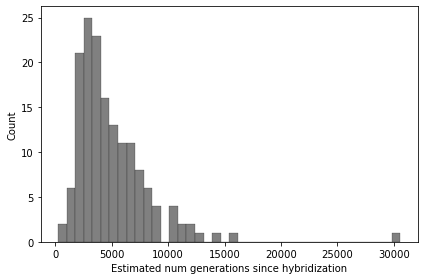

Mean time since hybridization in the NW African metapopulation is: 5064.843282
Median time since hybridization in the NW African metapopulation is: 4148.793563
Min time since hybridization in the NW African metapopulation is: 249.465524


In [589]:
indv_df=pd.read_csv("perc_bovis_per_indiv.csv", sep=",")
blocks_df=pd.read_csv("sb_hap_blocks_in_sh_nw_on_chr_gt_1mb.csv", sep=",", header=0)

gs=[]
#get dates from introgression tract lengths
for hap_id in tqdm(nw_hap_ids):
    l=blocks_df.loc[ (blocks_df["haplotype"] == hap_id) & (blocks_df["ancestry"] == "Sb"), "length"].mean()
    p=indv_df.loc[indv_df["Unnamed: 0"]==hap_id, "n_bovis_perc"].values[0]
    
    #calc from schumer paper
    # recomb rate from Sm.
    g=1/((l*3.4e-8)*p)
    gs.append(g)

plt.hist(gs, bins=40, color="grey",  edgecolor="black", linewidth=0.2)
plt.ylabel("Count".format(k))
plt.xlabel("Estimated num generations since hybridization")
plt.tight_layout()

plt.savefig("gens_since_hybridization_from_blocks.svg".format(k))
plt.savefig("gens_since_hybridization_from_blocks.png".format(k), dpi=300)
plt.show()

print("Mean time since hybridization in the NW African metapopulation is: {:2f}".format(np.mean(gs)))
print("Median time since hybridization in the NW African metapopulation is: {:2f}".format(np.median(gs)))
print("Min time since hybridization in the NW African metapopulation is: {:2f}".format(np.min(gs)))

### [TO DO] based on something else

# SNPeFF

# Selection

In [13]:
#read in the PHASED vcf file
p_callset=allel.read_vcf('{}/phasing/beagle_maf05.vcf'.format(results_dir))

#get relevant info
p_gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
p_chroms  = filtered_callset["variants/CHROM"]
p_samples = filtered_callset["samples"]
p_poss    = filtered_callset["variants/POS"]
p_var_ids = filtered_callset["variants/ID"]

p_uniq_chroms=np.unique(p_chroms)

## xpeHH & iHS

In [16]:
Path("{}/xpehh_and_ihs".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/xpehh_and_ihs".format(results_dir))

In [224]:
#get haplotypes for each population
h = p_gt.to_haplotypes()

sb_h=h[:, k_pop_idxs["sb"]]
nw_h=h[:, k_pop_idxs["sh_nw"]]
se_h=h[:, k_pop_idxs["sh_se"]]

100%|██████████| 564/564 [5:31:46<00:00, 35.30s/it]    


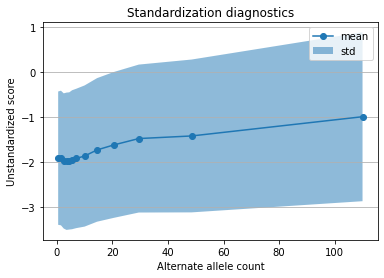

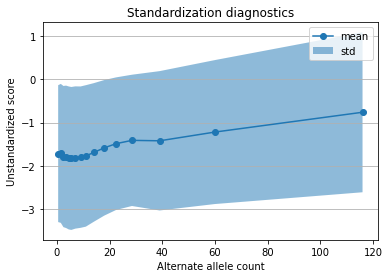

In [249]:
df=pd.DataFrame(columns=["chrom", "pos", "var_id", "xpehh", "nw_ihs", "se_ihs"])

for chrom in tqdm(p_uniq_chroms):   
#for chrom in ["NW_023366679.1"]:
    mask = p_chroms == chrom
    chrom_pos     = poss[mask]
    chrom_nw_h    = nw_h[mask]
    chrom_se_h    = se_h[mask]
#     chrom_sb_h    = sb_h[mask]
    chrom_var_ids = p_var_ids[mask]

    #xpehh
    xpehh  = allel.xpehh(chrom_nw_h, 
                         chrom_se_h, 
                         chrom_pos, 
                         min_ehh=0.1, 
                         include_edges=False, 
                         gap_scale=20_000, 
                         max_gap=200_000, 
                         is_accessible=None, 
                         use_threads=True)
    
    #nw africa ihs
    nw_ihs = allel.ihs(chrom_nw_h, 
                       chrom_pos, 
                       map_pos=None, 
                       min_ehh=0.1, 
                       min_maf=0.05, 
                       include_edges=False, 
                       gap_scale=20_000, 
                       max_gap=200_000, 
                       is_accessible=None, 
                       use_threads=True)
    
    #se africa ihs
    se_ihs = allel.ihs(chrom_se_h, 
                       chrom_pos, 
                       map_pos=None, 
                       min_ehh=0.1, 
                       min_maf=0.05, 
                       include_edges=False, 
                       gap_scale=20_000, 
                       max_gap=200_000, 
                       is_accessible=None, 
                       use_threads=True)
#     #nw africa ihs
#     sb_ihs = allel.ihs(chrom_sb_h, 
#                        chrom_pos, 
#                        map_pos=None, 
#                        min_ehh=0.1, 
#                        min_maf=0.05, 
#                        include_edges=False, 
#                        gap_scale=20_000, 
#                        max_gap=200_000, 
#                        is_accessible=None, 
#                        use_threads=True)
    
    #make chrom specific df for xpehh
    chr_df           = pd.DataFrame([xpehh, chrom_pos, chrom_var_ids, nw_ihs, se_ihs]).T
    chr_df.columns   = ["xpehh", "pos", "var_id", "nw_ihs", "se_ihs"]
    chr_df["chrom"]  = chrom
    chr_df           = chr_df[["chrom", "pos", "var_id", "xpehh", "nw_ihs", "se_ihs"]]
    
    #add to genomewide xpehh df
    df=df.append(chr_df)
    
#reset index
df=df.reset_index(drop=True)

#standardize xpehh
standardized_xpehhs = allel.standardize(df["xpehh"])
df["s_xpehh"] = standardized_xpehhs

#now standardize ihs for each pop
# - get alternate allele counts
se_aac = k_pop_acs["sh_se"][:,1]
nw_aac = k_pop_acs["sh_nw"][:,1]

#calculate standardized ihs
nw_sihs=allel.standardize_by_allele_count(list(df["nw_ihs"]), nw_aac)
se_sihs=allel.standardize_by_allele_count(list(df["se_ihs"]), nw_aac)

#add to the df
df["nw_sihs"] = nw_sihs[0]
df["se_sihs"] = se_sihs[0]

#save to a csv
df.to_csv("xpehh_ihs.csv", index=False, sep=",")

In [17]:
xpehh_df = pd.read_csv("xpehh_ihs.csv", sep=",")

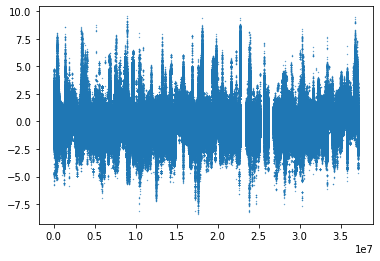

In [255]:
y_s = list(df["s_xpehh"])
x_s = list(range(0, len(df["s_xpehh"])))
           
plt.scatter(x_s, y_s, s=0.1)
plt.show()

In [18]:
# Ancestry at invadolysin
#NW_023366679.1:8567548-8600607

xpehh_chr_df = df.loc[ (df["chrom"] == "NW_023366679.1") ]

NameError: name 'df' is not defined

In [275]:
xpehh_chr_df

,chrom,pos,var_id,xpehh,nw_ihs,se_ihs,s_xpehh,nw_sihs,se_sihs
35854598,NW_023366679.1,2043,NW_023366679.1:2043,NaN,NaN,NaN,NaN,NaN,NaN
35854599,NW_023366679.1,2063,NW_023366679.1:2063,NaN,NaN,NaN,NaN,NaN,NaN
35854600,NW_023366679.1,2078,NW_023366679.1:2078,NaN,NaN,NaN,NaN,NaN,NaN
35854601,NW_023366679.1,2084,NW_023366679.1:2084,NaN,NaN,NaN,NaN,NaN,NaN
35854602,NW_023366679.1,2095,NW_023366679.1:2095,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
37052242,NW_023366679.1,11476638,NW_023366679.1:11476638,NaN,NaN,NaN,NaN,NaN,NaN
37052243,NW_023366679.1,11476642,NW_023366679.1:11476642,NaN,NaN,NaN,NaN,NaN,NaN
37052244,NW_023366679.1,11476647,NW_023366679.1:11476647,NaN,NaN,NaN,NaN,NaN,NaN
37052245,NW_023366679.1,11476663,NW_023366679.1:11476663,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
xpehh_chr_df.sort_values('s_xpehh', ascending=False)

,chrom,pos,var_id,xpehh,nw_ihs,se_ihs,s_xpehh,nw_sihs,se_sihs
36802270,NW_023366679.1,9209034,NW_023366679.1:9209034,4.026666,0.204579,-0.78486,9.487848,1.020606,0.395481
36802267,NW_023366679.1,9209014,NW_023366679.1:9209014,3.95077,0.125625,-0.161344,9.332546,0.972519,0.782378
36802272,NW_023366679.1,9209036,NW_023366679.1:9209036,3.851231,-0.372049,0.411667,9.128865,0.847929,1.312326
36802269,NW_023366679.1,9209033,NW_023366679.1:9209033,3.782411,NaN,NaN,8.98804,NaN,NaN
36802268,NW_023366679.1,9209031,NW_023366679.1:9209031,3.782411,NaN,NaN,8.98804,NaN,NaN
...,...,...,...,...,...,...,...,...,...
37052242,NW_023366679.1,11476638,NW_023366679.1:11476638,NaN,NaN,NaN,NaN,NaN,NaN
37052243,NW_023366679.1,11476642,NW_023366679.1:11476642,NaN,NaN,NaN,NaN,NaN,NaN
37052244,NW_023366679.1,11476647,NW_023366679.1:11476647,NaN,NaN,NaN,NaN,NaN,NaN
37052245,NW_023366679.1,11476663,NW_023366679.1:11476663,NaN,NaN,NaN,NaN,NaN,NaN


In [279]:
i_df = xpehh_chr_df.loc[ (xpehh_chr_df["pos"] > 8_567_548) &
                         (xpehh_chr_df["pos"] < 8_600_607) ]

In [281]:
i_df.dropna()

,chrom,pos,var_id,xpehh,nw_ihs,se_ihs,s_xpehh,nw_sihs,se_sihs
36751335,NW_023366679.1,8567553,NW_023366679.1:8567553,0.724161,-0.918081,-3.092465,2.730077,0.667814,-0.867539
36751353,NW_023366679.1,8567749,NW_023366679.1:8567749,0.737437,1.538378,0.620385,2.757245,2.327986,1.477991
36751354,NW_023366679.1,8567766,NW_023366679.1:8567766,0.741868,1.017664,-1.008595,2.766311,1.976067,0.448911
36751356,NW_023366679.1,8567791,NW_023366679.1:8567791,0.758053,1.241458,-2.907842,2.79943,2.127315,-0.750906
36751358,NW_023366679.1,8567803,NW_023366679.1:8567803,0.754799,1.094925,-1.63571,2.79277,2.028283,0.052741
...,...,...,...,...,...,...,...,...,...
36753735,NW_023366679.1,8600270,NW_023366679.1:8600270,-0.24075,-1.389076,-2.461347,0.755622,0.349497,-0.468841
36753746,NW_023366679.1,8600498,NW_023366679.1:8600498,-0.239901,-1.216881,-2.367133,0.75736,0.317743,-0.499051
36753753,NW_023366679.1,8600540,NW_023366679.1:8600540,-0.246278,-1.546594,-2.661738,0.74431,0.040904,-0.686958
36753755,NW_023366679.1,8600574,NW_023366679.1:8600574,-0.243716,-0.306948,-1.266179,0.749553,1.080841,0.286186


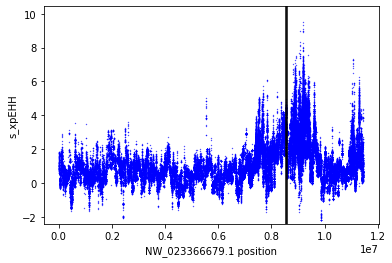

In [291]:
y_s = list(xpehh_chr_df.dropna()["s_xpehh"])
x_s = list(xpehh_chr_df.dropna()["pos"])

plt.scatter(x_s, y_s, s=0.1, c="blue", label="xpehh")

plt.vlines(8_567_548, -12, 12, colors="black")
plt.vlines(8_600_607, -12, 12, colors="black")

plt.xlabel("NW_023366679.1 position")
plt.ylabel("s_xpEHH")
plt.ylim(min(y_s) * 1.1 , max(y_s) * 1.1)        

#plt.savefig("xpehh.svg")
plt.savefig("xpehh.png", dpi=300)

plt.show()


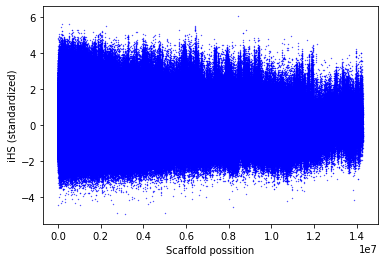

In [16]:
nw_y_s = list(xpehh_df.dropna(subset=["nw_sihs"])["nw_sihs"])
x_s    = list(xpehh_df.dropna(subset=["nw_sihs"])["pos"])

plt.scatter(x_s, nw_y_s, s=0.1, c="blue", label="siHS")

plt.xlabel("Scaffold possition")
plt.ylabel("iHS (standardized)")
#plt.ylim(min(y_s) * 1.1 , max(y_s) * 1.1)        

plt.savefig("nw_sihs.png", dpi=300)

plt.show()

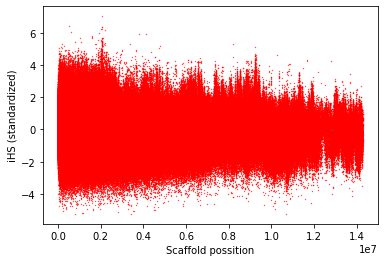

In [17]:
se_y_s = list(xpehh_df.dropna(subset=["se_sihs"])["se_sihs"])
x_s    = list(xpehh_df.dropna(subset=["se_sihs"])["pos"])

plt.scatter(x_s, se_y_s, s=0.1, c="red", label="siHS")

plt.xlabel("Scaffold possition")
plt.ylabel("iHS (standardized)")
#plt.ylim(min(y_s) * 1.1 , max(y_s) * 1.1)        

plt.savefig("nw_sihs.png", dpi=300)

plt.show()

In [ ]:
invadolysin_xpehh_df = xpehh_df.loc[xpehh_df["chrom"] == "NW_023366679.1"]

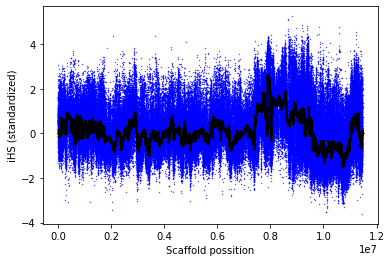

In [24]:
nw_y_s  = np.array(invadolysin_xpehh_df.dropna(subset=["nw_sihs"])["nw_sihs"])
snw_y_s = medfilt(nw_y_s, 1001)
nw_x_s  = list(invadolysin_xpehh_df.dropna(subset=["nw_sihs"])["pos"])

plt.scatter(nw_x_s, nw_y_s, s=0.1, c="blue", label="siHS")
plt.scatter(nw_x_s, snw_y_s, s=0.1, c="black", label="smoothed")

plt.xlabel("Scaffold possition")
plt.ylabel("iHS (standardized)")
#plt.ylim(min(y_s) * 1.1 , max(y_s) * 1.1)        

plt.savefig("nw_sihs.png", dpi=300)

plt.show()

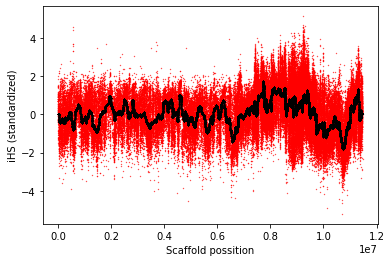

In [23]:
se_y_s = np.array(invadolysin_xpehh_df.dropna(subset=["se_sihs"])["se_sihs"])
sse_y_s = medfilt(se_y_s, 1001)
se_x_s = list(invadolysin_xpehh_df.dropna(subset=["se_sihs"])["pos"])

plt.scatter(se_x_s, se_y_s, s=0.1, c="red", label="siHS")
plt.scatter(se_x_s, sse_y_s, s=0.1, c="black", label="smoothed")

plt.xlabel("Scaffold possition")
plt.ylabel("iHS (standardized)")
#plt.ylim(min(y_s) * 1.1 , max(y_s) * 1.1)        

plt.savefig("se_sihs.png", dpi=300)

plt.show()

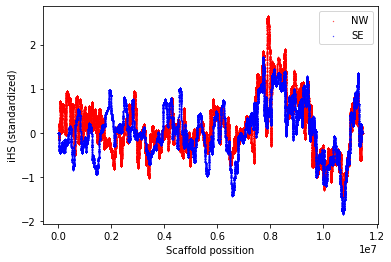

In [26]:
plt.scatter(nw_x_s, snw_y_s, s=0.1, c="red", label="NW")
plt.scatter(se_x_s, sse_y_s, s=0.1, c="blue", label="SE")

plt.legend()
plt.xlabel("Scaffold possition")
plt.ylabel("iHS (standardized)")
#plt.ylim(min(y_s) * 1.1 , max(y_s) * 1.1)        

plt.savefig("sihs.png", dpi=300)

plt.show()

In [ ]:
anc_df = pd.read_csv("{}/loter/perc_bovis_per_site.csv".format(results_dir), sep=",")
invadolysin_anc_df = anc_df.loc[anc_df["chrom"] == "NW_023366679.1"]

## delta Tajima's D

In [ ]:
allel.moving_delta_tajima_d(ac1, ac2, size, start=0, stop=None, step=None)

In [80]:
x=list(range(1,28))
np.lib.stride_tricks.sliding_window_view(x, 10)

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       [ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
       [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
       [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]])

In [ ]:
np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)

In [30]:
dtd_df=pd.DataFrame(columns=["chrom", "pos", "var_id", "delta_td"])

window_size = 100
for chrom in tqdm(uniq_chroms[0:1]):   
#for chrom in ["NW_023366679.1"]:
    mask = chroms == chrom
    chrom_pos      = poss[mask]
    chrom_nw_ac    = k_pop_acs["sh_nw"][mask]
    chrom_se_ac    = k_pop_acs["sh_se"][mask]
    chrom_var_ids  = var_ids[mask]

    
    #xpehh
    d_td = allel.moving_delta_tajima_d(chrom_nw_ac, chrom_se_ac, window_size)
    
#     #make chrom specific df for xpehh
#     chr_df           = pd.DataFrame([chrom_pos, chrom_var_ids, d_td, se_ihs]).T
#     chr_df.columns   = ["xpehh", "pos", "var_id", "nw_ihs", "se_ihs"]
#     chr_df["chrom"]  = chrom
#     chr_df           = chr_df[["chrom", "pos", "var_id", "xpehh", "nw_ihs", "se_ihs"]]
    
#     #add to genomewide xpehh df
#     df=df.append(chr_df)
    
# #reset index
# df=df.reset_index(drop=True)

# #standardize xpehh
# standardized_xpehhs = allel.standardize(df["xpehh"])
# df["s_xpehh"] = standardized_xpehhs

# #now standardize ihs for each pop
# # - get alternate allele counts
# se_aac = k_pop_acs["sh_se"][:,1]
# nw_aac = k_pop_acs["sh_nw"][:,1]

# #calculate standardized ihs
# nw_sihs=allel.standardize_by_allele_count(list(df["nw_ihs"]), nw_aac)
# se_sihs=allel.standardize_by_allele_count(list(df["se_ihs"]), nw_aac)

# #add to the df
# df["nw_sihs"] = nw_sihs[0]
# df["se_sihs"] = se_sihs[0]

# #save to a csv
# df.to_csv("xpehh_ihs.csv", index=False, sep=",")

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


## bayescan

## Volcanofinder

In [ ]:
Path("{}/volcanofinder".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/volcanofinder".format(results_dir))

In [ ]:
#read in pca_df and split into populations
pca_df["kmeans_label"]

In [ ]:
%%bash

cd ~/sch_hae_scan/bin/

wget http://degiorgiogroup.fau.edu/volcanofinder_v1.0.tar.gz

cd volcanofinder_v1.0

make

In [ ]:
%%bash 

#convert to vcf to volcanofinder format

#split into populations


vcftools \
    --vcf ../filter_genotypes/ingroup_indv_and_site_filt.vcf \
    --counts2 \
    --out ingroup_indv_and_site_filt

tail -n+2 ingroup_indv_and_site_filt.frq.count \
   | awk -v OFS="\t" '{print $2,$6,$4,"1"}' \
   >ingroup_indv_and_site_filt.in

echo -e 'position\tx\tn\tfolded' \
   | cat - ingroup_indv_and_site_filt.in \
   > temp && mv temp ingroup_indv_and_site_filt.in

In [ ]:
%%bash 

#calculate genome-wide sfs
SweepFinder2 -f smv7_ex_autosomes.in smv7_ex_autosomes.SpectFile

In [ ]:
conda activate sch_man_nwinvasion-sweepfinder

cd /master/nplatt/sch_man_nwinvasion/results/sweepfinder


for POP in brazil senegal niger tanzania; do
    mkdir $POP

    #get the pop specific sfs
    vcftools \
        --keep ~/sch_man_nwinvasion/results/lists/$POP.list \
        --vcf ../variant_filtration/smv7_ex_autosomes.vcf  \
        --counts2 \
        --stdout \
        >$POP/$POP.freq

    tail -n+2 $POP/$POP.freq  | awk -v OFS="\t" '{print $2,$6,$4,"1"}' >$POP/$POP.in

    echo -e 'position\tx\tn\tfolded' | cat - $POP/$POP.in > temp && mv temp $POP/$POP.in

    SweepFinder2 -f $POP/$POP.in $POP/$POP.sfs
 
    #run sweepfinder for each chrom
    for I in $(seq 1 7); do
        CHR=SM_V7_$I

        #convert vcf to sw input format
        vcftools \
            --keep ~/sch_man_nwinvasion/results/lists/$POP.list \
            --vcf ../variant_filtration/smv7_ex_autosomes.vcf \
            --chr $CHR \
            --counts2 \
            --stdout \
            >$POP/$CHR"_"$POP.freq

        tail -n+2 $POP/$CHR"_"$POP.freq  | awk -v OFS="\t" '{print $2,$6,$4,"1"}' >$POP/$CHR"_"$POP.in

        echo -e 'position\tx\tn\tfolded' | cat - $POP/$CHR"_"$POP.in > temp && mv temp $POP/$CHR"_"$POP.in

        #submit sweepfinder        
        CMD="conda activate sch_man_nwinvasion-sweepfinder; SweepFinder2 -lg 1000 $POP/$CHR"_"$POP.in $POP/$POP.sfs $POP/$CHR"_"$POP.sf2out"

        echo $CMD | qsub -V -cwd -S /bin/bash -q all.q -j y -N sf2r"$I"_"$POP" -o $POP/real_$CHR.log -pe smp 2
    done
done





